<a href="https://colab.research.google.com/github/alexmarc55/AI---Homework/blob/main/tema4AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generate_initial_population(num_nodes, pop_size):
    nodes = list(range(1, num_nodes))  # skip start node 0
    population = [random.sample(nodes, len(nodes)) for _ in range(pop_size)]
    return population


In [ ]:
def fitness(chromosome, m):
    # distance matrix, m

    score = 0

    for i, gene in enumerate(chromosome):
        if i == 0:
            score += m[0, gene] # edge between start node and first in chromosome
        else:
            score += m[chromosome[i-1], gene] # edge between any other pair of nodes

    score += m[0, chromosome[-1]] # edge connecting back to start node

    return 1000000/score # take the reciprocol and scale

Metode de selectii

In [ ]:
def tournament_selection(pop_size, fitness_scores):
    # tournament selection
    k = 5
    candidates = random.sample(range(pop_size), k)
    best = max(candidates, key=lambda i: fitness_scores[i])
    second = max([i for i in candidates if i != best], key=lambda i: fitness_scores[i])
    return [best, second]

def roulette_wheel_selection(pop_size, fitness_scores):
    total_fitness = sum(fitness_scores)

    def select_one():
        pick = random.uniform(0, total_fitness)
        current = 0
        for i, fitness in enumerate(fitness_scores):
            current += fitness
            if current > pick:
                return i
        return pop_size - 1

    return [select_one(), select_one()]

def rank_selection(pop_size, fitness_scores):
    """Rank-based Selection - selection based on rank, not absolute fitness"""
    # Sort indices by fitness
    ranked_indices = sorted(range(pop_size), key=lambda i: fitness_scores[i], reverse=True)

    # Create probabilities based on rank (rank 1 = best)
    ranks = list(range(pop_size, 0, -1))
    total_rank = sum(ranks)

    def select_one():
        pick = random.uniform(0, total_rank)
        current = 0
        for i, rank in enumerate(ranks):
            current += rank
            if current > pick:
                return ranked_indices[i]
        return ranked_indices[-1]

    return [select_one(), select_one()]

Metode de crossover

In [ ]:
def order_based_crossover(parent1, parent2, num_nodes_to_select=None):
  size = len(parent1)
  num_nodes_to_select = max(3, len(parent1) // 5) if num_nodes_to_select is None else num_nodes_to_select
  selected_genes = random.sample(parent1, num_nodes_to_select)
  order_p1 = [gene for gene in parent1 if gene in selected_genes]
  order_p2 = [gene for gene in parent2 if gene in selected_genes]

  child1 = parent1.copy()
  child2 = parent2.copy()

  # We reorder the nodes to be in the same order as the parent1's nodes
  idxs = [i for i, gene in enumerate(child1) if gene in selected_genes]
  for idx, gene in zip(idxs, order_p2):
      child1[idx] = gene

  # We reorder the nodes to be in the same order as the parent2's nodes
  idxs = [i for i, gene in enumerate(child2) if gene in selected_genes]
  for idx, gene in zip(idxs, order_p1):
        child2[idx] = gene

  return child1, child2


def pmx_crossover(p1, p2):
    """Partially Mapped Crossover - preserves relative relationships between genes"""
    size = len(p1)
    cx1, cx2 = sorted(random.sample(range(size), 2))

    child1, child2 = [None]*size, [None]*size

    # Copy crossover segment
    child1[cx1:cx2] = p1[cx1:cx2]
    child2[cx1:cx2] = p2[cx1:cx2]

    def fill_child(child, p_source, p_segment):
        for i in range(size):
            if child[i] is None:
                gene = p_source[i]
                # If gene is already in segment, find the mapping
                while gene in child[cx1:cx2]:
                    idx = p_segment.index(gene)
                    gene = p_source[cx1 + (idx - cx1)]
                child[i] = gene
        return child

    child1 = fill_child(child1, p2, p1[cx1:cx2])
    child2 = fill_child(child2, p1, p2[cx1:cx2])

    return child1, child2

def cycle_crossover(p1, p2):
    """Cycle Crossover - preserves absolute position of genes"""
    size = len(p1)
    child1, child2 = [None]*size, [None]*size

    visited = [False] * size

    while None in child1:
        # Find first unvisited position
        idx = child1.index(None)

        # Create a cycle
        cycle_start = idx
        while not visited[idx]:
            visited[idx] = True
            child1[idx] = p1[idx]
            child2[idx] = p2[idx]
            # Find next position in cycle
            idx = p1.index(p2[idx])

        # Swap children for next cycle
        child1, child2 = child2, child1

    return child1, child2

Metode de mutatii

In [ ]:
# swap mutation - swap 2 values in a chromosome
def mutate1(x):
  # random choice
  index = np.random.choice(range(len(x)), size=2, replace=False)

  # swap values
  temp = x[index[0]]
  x[index[0]] = x[index[1]]
  x[index[1]] = temp

  return x

# random insertion - remove a value and re-insert it in a random
def mutate2(x):
    x = x.copy()  # ensure we don’t mutate in place accidentally
    i, j = random.sample(range(len(x)), 2)
    gene = x.pop(i)
    x.insert(j, gene)
    return x

def inversion_mutation(x):
    """Inversion - reverses a segment"""
    x = x.copy()
    i, j = sorted(random.sample(range(len(x)), 2))
    x[i:j+1] = reversed(x[i:j+1])
    return x


def scramble_mutation(x):
    """Scramble - shuffles a random segment"""
    x = x.copy()
    i, j = sorted(random.sample(range(len(x)), 2))
    segment = x[i:j+1]
    random.shuffle(segment)
    x[i:j+1] = segment
    return x


def displacement_mutation(x):
    """Displacement - moves an entire segment to another position"""
    x = x.copy()
    size = len(x)

    # Select a segment
    i, j = sorted(random.sample(range(size), 2))
    segment = x[i:j+1]

    # Remove segment
    for _ in range(j - i + 1):
        x.pop(i)

    # Insert segment at new position
    new_pos = random.randint(0, len(x))
    x[new_pos:new_pos] = segment

    return x


In [ ]:
def generate_graph(num_nodes=52, min_dist=10, max_dist=100):
    m = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            dist = random.randint(min_dist, max_dist)
            m[i, j] = dist
            m[j, i] = dist

    np.fill_diagonal(m, 0)
    return m

Main algorithm cu order based crossover, swap and insert mutation and tournament selection

In [ ]:
def run_ga(population, fitness_scores, m, generations=100, mutation_rate=0.2):
    pop_size = len(population)
    best_fitness_history = []

    for gen in range(generations):
        new_population = []

        # Elitism - keep top 2 solutions
        new_population.extend(population[:2])

        # Generate rest of population
        while len(new_population) < pop_size:
            # Selection
            parent_indices = tournament_selection(pop_size, fitness_scores)
            parent1 = population[parent_indices[0]]
            parent2 = population[parent_indices[1]]

            # Crossover
            child1, child2 = order_based_crossover(parent1, parent2)

            # Mutation
            if random.random() < mutation_rate:
                child1 = mutate1(child1)
            if random.random() < mutation_rate:
                child2 = mutate2(child2)

            new_population.extend([child1, child2])

        new_population = new_population[:pop_size]

        # Evaluate fitness
        population = new_population
        fitness_scores = [fitness(ind, m) for ind in population]

        # Sort by fitness
        order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
        population = [population[i] for i in order]
        fitness_scores = sorted(fitness_scores, reverse=True)

        best_fitness_history.append(fitness_scores[0])

        if gen % 10 == 0:
            print(f"Generation {gen}: Best Fitness = {fitness_scores[0]:.3f}, Best Path = {population[0]}")

    return population, fitness_scores, best_fitness_history

m = generate_graph(num_nodes=12, min_dist=10, max_dist=100)
population = generate_initial_population(num_nodes=10, pop_size=20)

# evaluate the fitness of our population (using parallel array)
fitness_scores = [ fitness(i, m) for i in population]

# sort population by their fitness score
order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
population = [population[i] for i in order]
fitness_scores = sorted(fitness_scores, reverse=True)
final_pop, final_fitness, history = run_ga(population, fitness_scores, m, generations=100)


Generation 0: Best Fitness = 2375.297, Best Path = [2, 8, 4, 5, 7, 9, 1, 6, 3]
Generation 10: Best Fitness = 3164.557, Best Path = [4, 8, 2, 3, 7, 5, 9, 1, 6]
Generation 20: Best Fitness = 3164.557, Best Path = [4, 8, 2, 3, 7, 5, 9, 1, 6]
Generation 30: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 40: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 50: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 60: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 70: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 80: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]
Generation 90: Best Fitness = 3236.246, Best Path = [8, 2, 3, 7, 5, 9, 1, 6, 4]


GA Algorithm cu cycle crossover si scramble,displacement mutation - rezultate mai bune ( 12 noduri )

In [ ]:
def run_ga2(population, fitness_scores, m, generations=100, mutation_rate=0.2):
    pop_size = len(population)
    best_fitness_history = []

    for gen in range(generations):
        new_population = []

        # Elitism - keep top 2 solutions
        new_population.extend(population[:2])

        # Generate rest of population
        while len(new_population) < pop_size:
            # Selection
            parent_indices = rank_selection(pop_size, fitness_scores)
            parent1 = population[parent_indices[0]]
            parent2 = population[parent_indices[1]]

            # Crossover
            child1, child2 = cycle_crossover(parent1, parent2)

            # Mutation
            if random.random() < mutation_rate:
                child1 = scramble_mutation(child1)
            if random.random() < mutation_rate:
                child2 = displacement_mutation(child2)

            new_population.extend([child1, child2])

        new_population = new_population[:pop_size]

        # Evaluate fitness
        population = new_population
        fitness_scores = [fitness(ind, m) for ind in population]

        # Sort by fitness
        order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
        population = [population[i] for i in order]
        fitness_scores = sorted(fitness_scores, reverse=True)

        best_fitness_history.append(fitness_scores[0])

        if gen % 10 == 0:
            print(f"Generation {gen}: Best Fitness = {fitness_scores[0]:.3f}, Best Path = {population[0]}")

    return population, fitness_scores, best_fitness_history

final_pop, final_fitness, history = run_ga2(population, fitness_scores, m, generations=100)


Generation 0: Best Fitness = 2392.344, Best Path = [4, 2, 6, 5, 7, 3, 9, 1, 8]
Generation 10: Best Fitness = 2518.892, Best Path = [4, 7, 3, 2, 9, 5, 6, 1, 8]
Generation 20: Best Fitness = 3003.003, Best Path = [4, 7, 3, 6, 1, 5, 9, 2, 8]
Generation 30: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 40: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 50: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 60: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 70: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 80: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]
Generation 90: Best Fitness = 3496.503, Best Path = [4, 7, 3, 6, 1, 9, 5, 2, 8]


Pentru n= 40 noduri:

In [ ]:
m = generate_graph(num_nodes=40, min_dist=10, max_dist=100)
population = generate_initial_population(num_nodes=40, pop_size=200)

# evaluate the fitness of our population (using parallel array)
fitness_scores = [ fitness(i, m) for i in population]

# sort population by their fitness score
order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
population = [population[i] for i in order]
fitness_scores = sorted(fitness_scores, reverse=True)
final_pop, final_fitness, history = run_ga(population, fitness_scores, m, generations=3000)
print("\n=== FINAL SOLUTION FOR GA 1 ===")
best_route = [0] + final_pop[0] + [0]
print(f"Best route: {best_route}")
print(f"Best fitness: {final_fitness[0]:.3f}")
print(f"Total distance: {1000000/final_fitness[0]:.2f}")
print("/n=========================")
final_pop, final_fitness, history = run_ga2(population, fitness_scores, m, generations=3000)
print("\n=== FINAL SOLUTION FOR GA 2 ===")
best_route = [0] + final_pop[0] + [0]
print(f"Best route: {best_route}")
print(f"Best fitness: {final_fitness[0]:.3f}")
print(f"Total distance: {1000000/final_fitness[0]:.2f}")

Generation 0: Best Fitness = 572.082, Best Path = [36, 31, 11, 21, 38, 19, 16, 7, 18, 35, 39, 37, 4, 26, 29, 23, 27, 13, 9, 15, 25, 8, 3, 17, 12, 5, 6, 30, 14, 20, 1, 10, 32, 28, 24, 34, 2, 33, 22]
Generation 10: Best Fitness = 674.309, Best Path = [29, 8, 39, 33, 28, 20, 14, 32, 22, 5, 3, 7, 2, 12, 25, 15, 16, 9, 37, 11, 24, 17, 21, 6, 19, 27, 1, 31, 10, 36, 35, 18, 23, 4, 30, 26, 13, 38, 34]
Generation 20: Best Fitness = 684.463, Best Path = [29, 8, 23, 33, 28, 20, 14, 32, 22, 7, 3, 39, 2, 12, 25, 15, 16, 9, 37, 11, 24, 17, 21, 6, 19, 27, 1, 31, 10, 36, 35, 26, 5, 4, 30, 18, 13, 38, 34]
Generation 30: Best Fitness = 705.716, Best Path = [19, 29, 2, 3, 33, 28, 32, 14, 17, 23, 20, 7, 24, 10, 39, 35, 36, 9, 21, 38, 16, 6, 15, 12, 5, 37, 8, 1, 11, 25, 26, 4, 18, 30, 27, 13, 34, 22, 31]
Generation 40: Best Fitness = 784.929, Best Path = [19, 29, 2, 3, 33, 28, 32, 14, 17, 9, 20, 7, 24, 10, 39, 35, 36, 23, 21, 38, 16, 6, 15, 12, 5, 37, 8, 1, 11, 25, 26, 18, 4, 30, 27, 13, 34, 22, 31]
Genera

=== FINAL SOLUTION FOR GA 1 ===
Best route: [0, 38, 4, 17, 21, 12, 37, 1, 13, 10, 39, 23, 28, 27, 32, 16, 34, 9, 35, 3, 29, 31, 14, 5, 30, 26, 2, 33, 11, 24, 7, 15, 18, 36, 6, 20, 19, 25, 8, 22, 0]
Best fitness: 1540.832
Total distance: 649.00

=== FINAL SOLUTION FOR GA 2 ===
Best route: [0, 14, 5, 18, 15, 35, 3, 38, 4, 17, 21, 12, 13, 1, 37, 25, 19, 22, 33, 30, 26, 2, 24, 7, 8, 11, 36, 23, 39, 10, 9, 28, 27, 29, 31, 6, 20, 32, 16, 34, 0]
Best fitness: 1652.893
Total distance: 605.00

Observam ca si la n = 40 al doilea este putin mai eficient

20 cazuri in tabel

In [ ]:
import time
import pandas as pd

# combinatii de metode
selection_methods = {
    "tournament": tournament_selection,
    "roulette": roulette_wheel_selection,
    "rank": rank_selection
}

crossover_methods = {
    "order_based": order_based_crossover,
    "cycle": cycle_crossover,
    "pmx": pmx_crossover
}

mutation_methods = {
    "swap": mutate1,
    "insert": mutate2,
    "scramble": scramble_mutation,
    "displacement": displacement_mutation,
    "inversion": inversion_mutation
}

# parametri globali
num_nodes = 40
m = generate_graph(num_nodes=num_nodes, min_dist=10, max_dist=100)

# listă pentru rezultate
results = []

test_id = 1

for sel_name, sel_func in selection_methods.items():
    for cross_name, cross_func in crossover_methods.items():
        for mut_name, mut_func in list(mutation_methods.items())[:2]:  # primele 2 tipuri de mutație
            pop_size = random.choice([100, 200])
            generations = random.choice([1000, 2000, 3000])
            mutation_rate = random.choice([0.1, 0.2, 0.3])

            # inițializare populație
            population = generate_initial_population(num_nodes=num_nodes, pop_size=pop_size)
            fitness_scores = [fitness(ind, m) for ind in population]

            order = np.array(sorted([*enumerate(fitness_scores)], key=lambda x: x[1], reverse=True), dtype=int)[:, 0]
            population = [population[i] for i in order]
            fitness_scores = sorted(fitness_scores, reverse=True)

            # rulare algoritm și cronometrare
            start_time = time.time()

            # alegem tipul de GA în funcție de metode
            if cross_name == "cycle":
                final_pop, final_fitness, history = run_ga2(population, fitness_scores, m, generations=generations, mutation_rate=mutation_rate)
            else:
                final_pop, final_fitness, history = run_ga(population, fitness_scores, m, generations=generations, mutation_rate=mutation_rate)

            exec_time = time.time() - start_time

            best_distance = 1000000 / final_fitness[0]
            results.append([
                test_id,
                sel_name,
                cross_name,
                mut_name,
                pop_size,
                generations,
                mutation_rate,
                best_distance,
                final_fitness[0],
                round(exec_time, 2)
            ])
            test_id += 1

# creăm DataFrame-ul
columns = [
    "Nr. Test",
    "Tip Selectie",
    "Tip Crossover",
    "Tip Mutatie",
    "Nr. Populatie",
    "Nr. Generatii",
    "Rata de Mutatie",
    "Cea mai buna distanta",
    "Fitness maxim",
    "Timp executie (s)"
]

df_results = pd.DataFrame(results, columns=columns)

# afișăm rezultatele
print(df_results)

# opțional: export în Excel / CSV
df_results.to_excel("rezultate_GA.xlsx", index=False)


Generation 0: Best Fitness = 556.793, Best Path = [32, 34, 3, 19, 39, 27, 35, 1, 6, 12, 29, 11, 14, 8, 31, 30, 26, 15, 23, 20, 18, 37, 28, 21, 7, 5, 17, 13, 9, 4, 33, 25, 16, 22, 10, 2, 38, 24, 36]
Generation 10: Best Fitness = 660.502, Best Path = [8, 9, 4, 18, 11, 5, 14, 3, 21, 26, 25, 19, 35, 2, 31, 37, 38, 32, 24, 12, 15, 30, 28, 1, 23, 34, 33, 10, 20, 7, 6, 39, 29, 36, 16, 17, 13, 22, 27]
Generation 20: Best Fitness = 718.391, Best Path = [37, 9, 26, 18, 10, 3, 20, 31, 21, 4, 11, 5, 8, 35, 12, 28, 30, 24, 32, 19, 2, 15, 25, 38, 1, 6, 23, 33, 34, 14, 7, 39, 29, 36, 16, 17, 13, 22, 27]
Generation 30: Best Fitness = 797.448, Best Path = [37, 9, 4, 18, 10, 3, 20, 31, 21, 26, 11, 5, 35, 8, 12, 28, 30, 24, 32, 19, 2, 15, 25, 38, 7, 1, 23, 33, 34, 14, 6, 39, 29, 36, 16, 17, 13, 22, 27]
Generation 40: Best Fitness = 879.507, Best Path = [37, 9, 4, 18, 3, 20, 31, 21, 26, 11, 5, 35, 8, 12, 15, 10, 30, 28, 32, 19, 2, 24, 25, 38, 7, 1, 23, 33, 34, 14, 6, 39, 29, 36, 16, 17, 13, 22, 27]
Genera

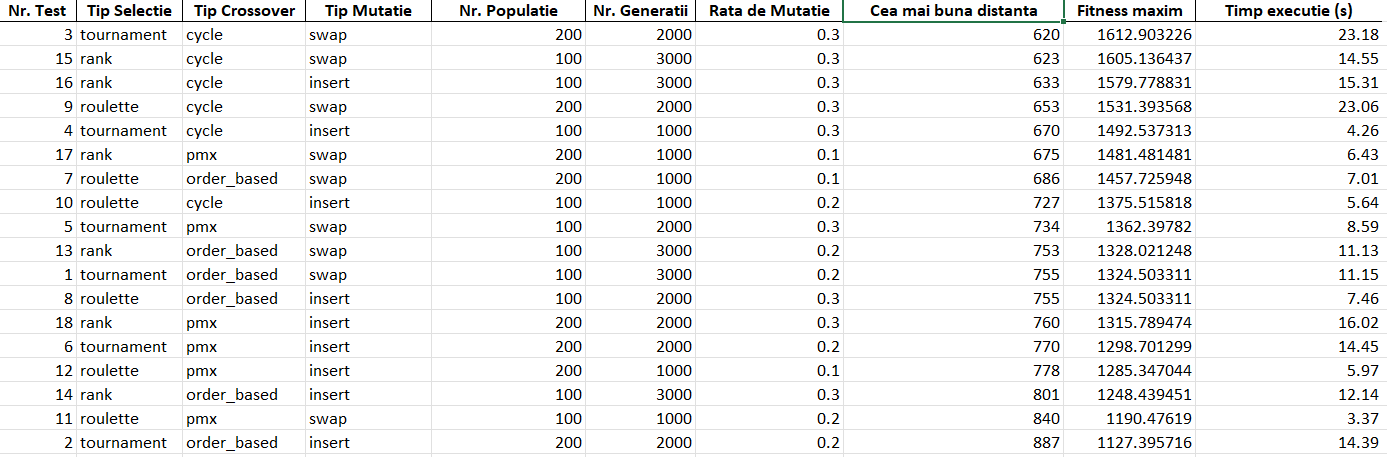